# Nifty50 Closing Price Prediction using ML

* Model: Stacked LSTM
* Dataset: Nifty50 from Yahoo Fianance

## Initialization

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df = pd.read_csv('./dataset/NIFTY50.csv')
df.index = pd.to_datetime(df['Date']).dt.date

df.drop(['Date', 'Adj Close'], axis='columns', inplace=True)
display(df.head())
display(df.tail())

,Open,High,Low,Close
Date,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805


,Open,High,Low,Close
Date,,,,
2021-04-26,14449.45020,14557.50000,14421.29981,14485.00000
2021-04-27,14493.79981,14667.54981,14484.84961,14653.04981
2021-04-28,14710.50000,14890.25000,14694.95020,14864.54981
2021-04-29,14979.00000,15044.34961,14814.45020,14894.90039
2021-04-30,14747.34961,14855.45020,14601.70020,14631.09961


In [3]:
print(f'Dataset Shape: {df.shape}\n')
display(df.info())

Dataset Shape: (3326, 4)

<class 'pandas.core.frame.DataFrame'>
Index: 3326 entries, 2007-09-17 to 2021-04-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3326 non-null   float64
 1   High    3326 non-null   float64
 2   Low     3326 non-null   float64
 3   Close   3326 non-null   float64
dtypes: float64(4)
memory usage: 129.9+ KB


None

In [4]:
window_len = 5
feature = 'Open'

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

In [6]:
df_train.head()

,Open,High,Low,Close
Date,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805


In [7]:
df_test.head()

,Open,High,Low,Close
Date,,,,
2018-08-07,11423.15039,11428.95020,11359.70020,11389.4502
2018-08-08,11412.50000,11459.95020,11379.29981,11450.0000
2018-08-09,11493.25000,11495.20020,11454.09961,11470.7002
2018-08-10,11474.95020,11478.75000,11419.65039,11429.5000
2018-08-13,11369.59961,11406.29981,11340.29981,11355.7500


## Plotting Closing Prices

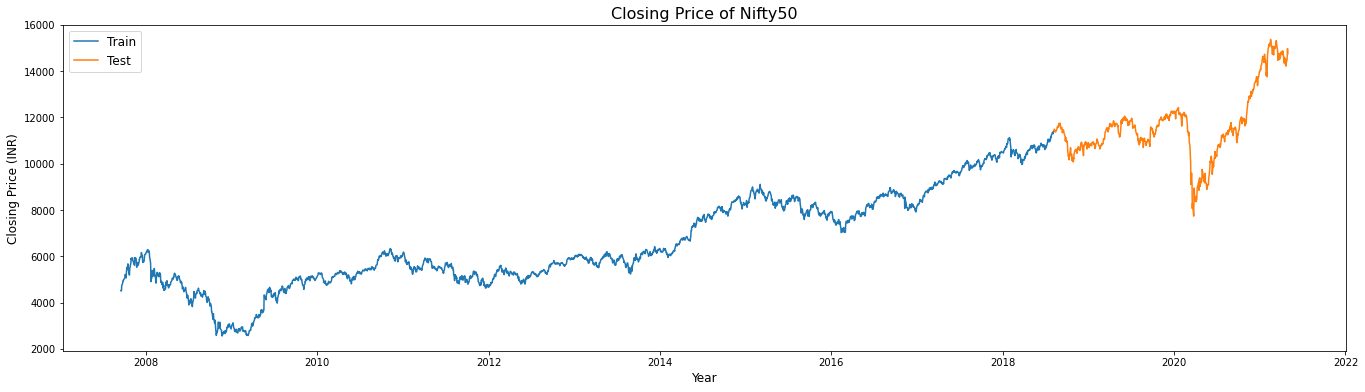

In [8]:
fig, ax = plt.subplots(figsize=(23, 6))
ax.plot(df_train[feature], label='Train')
ax.plot(df_test[feature], label='Test')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Closing Price (INR)', fontsize=12)
ax.set_title('Closing Price of Nifty50', fontsize=16)
ax.legend(fontsize=12)

## Data Preprocessing

In [9]:
train = np.array(df_train[feature]).reshape(-1, 1)
test  = np.array(df_test [feature]).reshape(-1, 1)

### Imputation

* Needed if null values present

In [10]:
print(f'Null value count:\n{df.isnull().sum()}')

Null value count:
Open     0
High     0
Low      0
Close    0
dtype: int64


### Feature Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)

train_sc = scaler.transform(train)
test_sc  = scaler.transform(test )

print(f'Scaled Training Set Example:', train_sc[0])
print(f'Scaled Testing  Set Example:', test_sc [0])

Scaled Training Set Example: [0.22206966]
Scaled Testing  Set Example: [1.00244695]


In [12]:
def to_time_windows(data, window_len):
    windows = []
    for i in range(len(data) - window_len):
        windows.append(data[i:i+window_len])
    return np.array(windows)

X_train_sc = to_time_windows(train_sc, window_len)
X_test_sc  = to_time_windows(test_sc , window_len)

y_train_sc = train_sc[window_len:]
y_test_sc  = test_sc [window_len:]

y_train = scaler.inverse_transform(y_train_sc)
y_test  = scaler.inverse_transform(y_test_sc)

## Models

### Model 1: Stacked LSTM

#### Build Model

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

def stacked_LSTM_model(data, window_len):
    # Initialising
    model = Sequential()
    
    # Layer 1, shape = (window length, no of features)
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_len, len(data[0][0]))))
    model.add(Dropout(0.2))
    
    # Layer 2
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Output Layer
    model.add(Dense(units=1))
    model.add(Activation('relu'))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    display(model.summary())
    return model

model = stacked_LSTM_model(X_train_sc, window_len)
# Fitting to training set
model.fit(X_train_sc, y_train_sc, epochs=100, batch_size=64, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
____________________________________________________

None

#### Test Model

In [14]:
# Testing the model
y_train_pred = scaler.inverse_transform(model.predict(X_train_sc))
y_test_pred  = scaler.inverse_transform(model.predict(X_test_sc ))

# Calculating Accuracy
train_error = mean_squared_error(y_train_pred, y_train, squared=False)
test_error  = mean_squared_error(y_test_pred , y_test , squared=False)

print(f'Mean Training Error:', round(train_error, 2))
print(f'Mean Testing  Error:', round(test_error , 2))

print(f'Train Accuracy: {round(100*r2_score(y_train_pred , y_train), 2)}%')
print(f'Test  Accuracy: {round(100*r2_score(y_test_pred  , y_test ), 2)}%')

Mean Training Error: 140.11
Mean Testing  Error: 363.8
Train Accuracy: 99.51%
Test  Accuracy: 92.5%


#### Plot Model

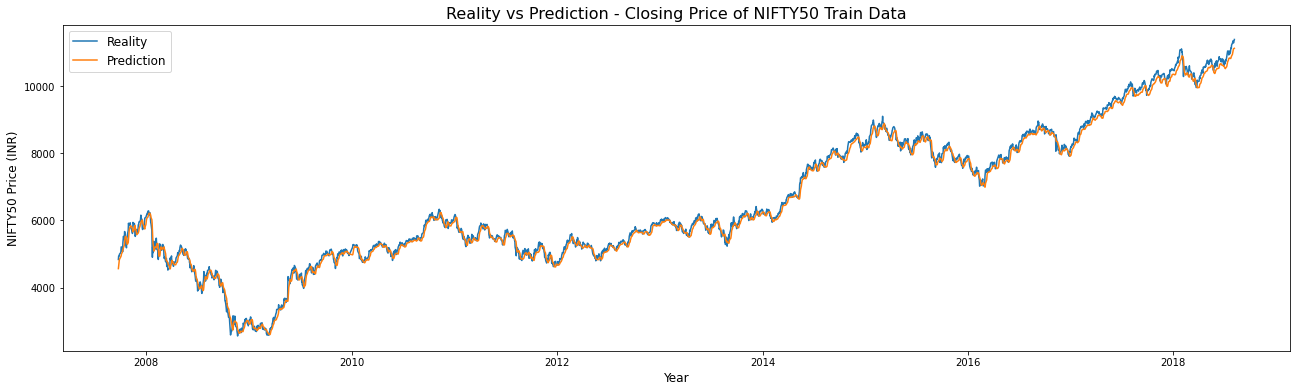

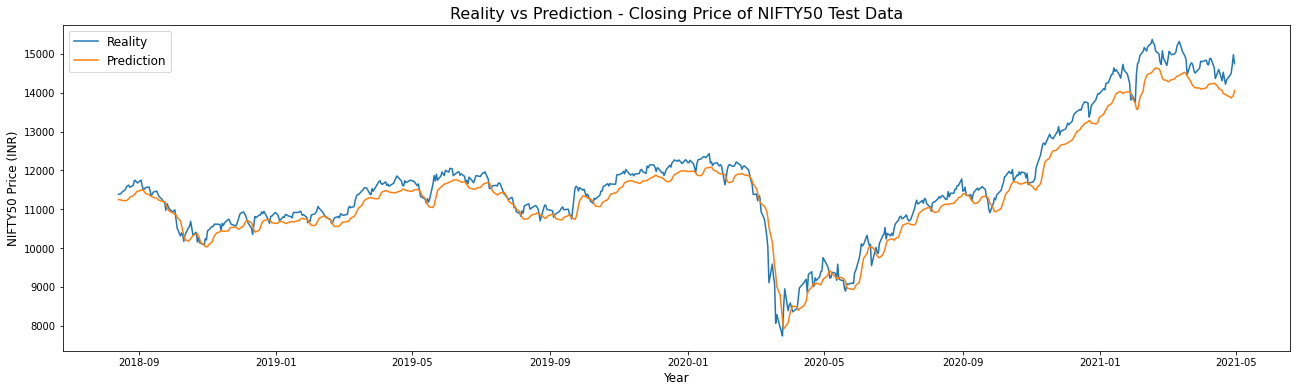

In [15]:
# Plotting Training Data
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(df_train[feature][window_len:].index, y_train, label='Reality')
ax.plot(df_train[feature][window_len:].index, y_train_pred, label='Prediction')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('NIFTY50 Price (INR)', fontsize=12)
ax.set_title('Reality vs Prediction - Closing Price of NIFTY50 Train Data', fontsize=16)
ax.legend(fontsize=12)

# Plotting Testing Data
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(df_test[feature][window_len:].index, y_test, label='Reality')
ax.plot(df_test[feature][window_len:].index, y_test_pred, label='Prediction')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('NIFTY50 Price (INR)', fontsize=12)
ax.set_title('Reality vs Prediction - Closing Price of NIFTY50 Test Data', fontsize=16)
ax.legend(fontsize=12)

### Model 2: ARIMA

#### Build Model

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model and Predict
history = list(train)
order_predictions = []

for i in range(len(test)):
    model = ARIMA(history, order=(2 ,2 ,0)) # defining ARIMA model
    model_fit = model.fit() # fitting model
    y_hat = model_fit.forecast() # predicting 'return'

    order_predictions.append(y_hat[0]) # first element ([0][0]) is a prediction
    history.append(test[i]) # simply adding following day 'return' value to the model
    print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')

pred = np.array(order_predictions)

#### Test Model

In [17]:
# Mean Error
error = mean_squared_error(test, order_predictions, squared=False)
print('Test MSE: %.3f' % error)
accuracy = r2_score(test, order_predictions)
print(f'Test Accuracy: {round(100*r2_score(test, order_predictions), 2)}%')

Test MSE: 175.247
Test Accuracy: 98.58%


#### Plot Model

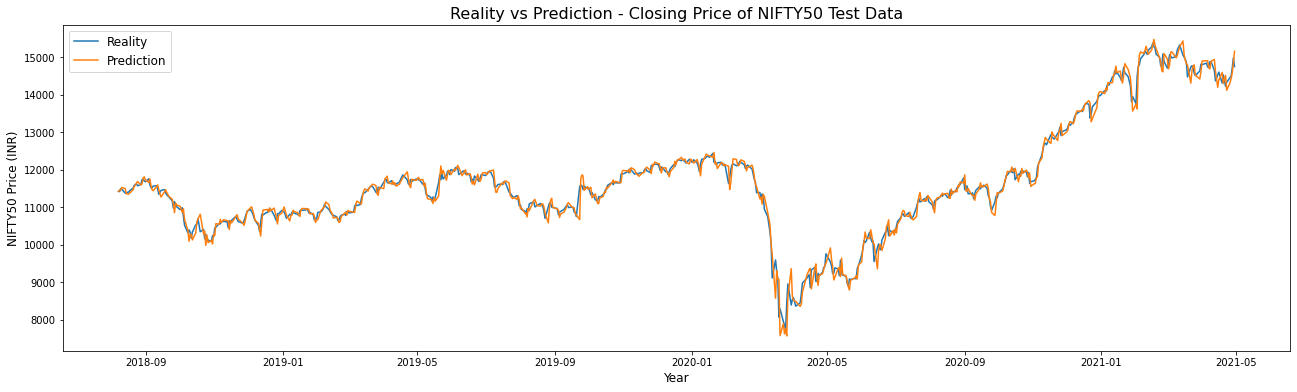

In [19]:
# Plotting Prediction vs Reality
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(df_test[feature].index, test, label='Reality')
ax.plot(df_test[feature].index, order_predictions, label='Prediction')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('NIFTY50 Price (INR)', fontsize=12)
ax.set_title('Reality vs Prediction - Closing Price of NIFTY50 Test Data', fontsize=16)
ax.legend(fontsize=12)

### Model 3: CNN